# Normal Normal

In [13]:
import torch
import torch.nn as nn
import torch.distributions as dist
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

import beanmachine.ppl as bm

class NormalNormal:
    @bm.random_variable
    def mu(self):
        return dist.Normal(0, 1)
    
    @bm.random_variable
    def x(self, i):
        return dist.Normal(self.mu(), 1)
model = NormalNormal()
queries = [model.mu()]
obs = {
    model.x(0): torch.tensor(10.0),
}

def true_log_prob(x):
    tau_0 = 1.0**-2
    tau_1 = 1.0**-2
    return dist.Normal((tau_1 / (tau_0 + tau_1)) * 10.0, (tau_0 + tau_1)**-1).log_prob(x)
    


In [14]:
from beanmachine.ppl.experimental.vi.VariationalInfer import MeanFieldVariationalInference

vi = MeanFieldVariationalInference()
vi_dicts = vi.infer(queries, obs, base_dist=dist.Normal, base_args={
    'loc': nn.Parameter(torch.tensor(0.)),
    'scale': torch.tensor(1.),
}, num_iter=100, lr=1e-1)

In [15]:
fs = vi_dicts[model.mu()].flow_stack
fs.base_dist(**fs.base_args)

Normal(loc: 3.7276110649108887, scale: 1.0)

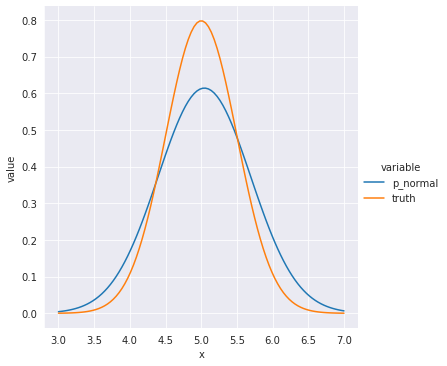

In [16]:
x = torch.linspace(3, 7).unsqueeze(1)
p_normal = torch.exp(vi_dicts[model.mu()].log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "truth":  torch.exp(true_log_prob(x)).flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

# Using a heavy-tailed base distribution

In [17]:
import torch
import torch.nn as nn
from beanmachine.ppl.experimental.vi.VariationalInfer import MeanFieldVariationalInference

vi = MeanFieldVariationalInference()

vi_dicts_student = vi.infer(
    queries, obs, 
    base_dist=dist.StudentT,
    base_args={
        #'df': torch.tensor(1000000.0),
        'df': nn.Parameter(torch.tensor(10.0)),
        'loc': torch.tensor(0.0),
        #'loc': nn.Parameter(torch.tensor(0.0)),
        #'scale': torch.tensor(1.0),
        #'scale': nn.Parameter(torch.tensor(1.0)),
    },
    num_iter=100, lr=1)

#)

In [18]:
fs = vi_dicts_student[model.mu()].flow_stack
fs.base_dist(**fs.base_args)

StudentT(df: 10.461636543273926, loc: 0.0, scale: 1.0)

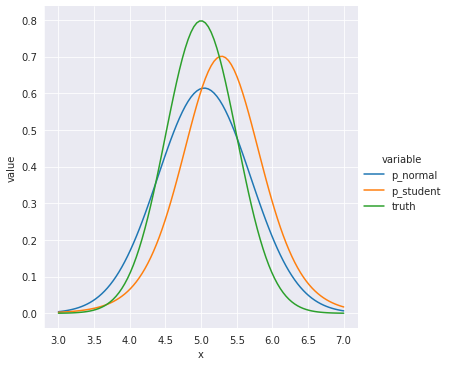

In [19]:
p_student = torch.exp(vi_dicts_student[model.mu()].log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "p_student": p_student.flatten().detach().numpy(),
    "truth":  torch.exp(true_log_prob(x)).flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

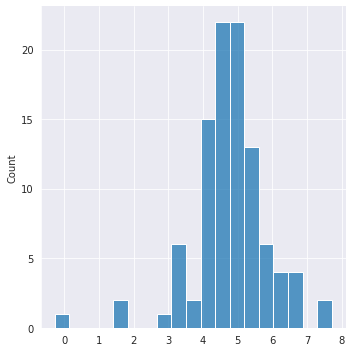

In [30]:
sns.displot(vi_dicts_student[model.mu()].sample((100,)).detach().numpy().flatten())

# Scale Mixture Representation for StudentT
[Ref](https://proceedings.neurips.cc/paper/2009/file/13fe9d84310e77f13a6d184dbf1232f3-Paper.pdf)

In [120]:
import torch
import torch.distributions as dist
import torch.nn as nn

import beanmachine.ppl as bm
from beanmachine.ppl.experimental.vi.VariationalInfer import MeanFieldVariationalInference

df = 8.0

@bm.random_variable
def v(i):
    return dist.Chi2(df)

@bm.random_variable
def y(i):
    return dist.Normal(0, torch.sqrt(torch.abs(v(i))))

vi = MeanFieldVariationalInference()
vi_dicts = vi.infer(
    [y(i) for i in range(1)], {}, 
    base_dist=dist.StudentT,
    base_args={
        #'df': torch.tensor(1.0*df, requires_grad=False),
        'df': nn.Parameter(torch.tensor(df)),
        'loc': torch.tensor(0.),
        #'loc': nn.Parameter(torch.tensor(0.0)),
        #'scale': torch.tensor(1.0),
        #'scale': nn.Parameter(torch.tensor(1.0)),
    },
    num_iter=100, lr=5e-1)

#)

vi_dicts_normal = vi.infer(
    [y(i) for i in range(1)], {}, 
    num_iter=100, lr=5e-1)

def true_log_prob(x):
    return dist.StudentT(df=df).log_prob(x)

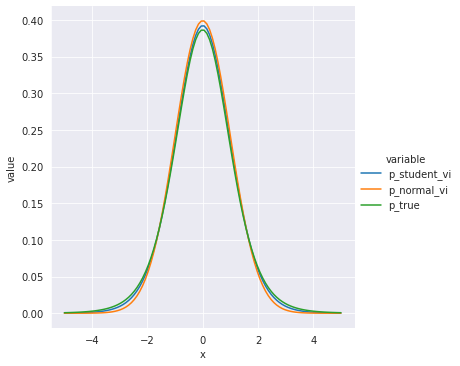

In [121]:
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

x = torch.linspace(-5, 5).unsqueeze(1)
p = torch.exp(vi_dicts[y(0)].log_prob(x))
p_true = torch.exp(true_log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_student_vi": p.flatten().detach().numpy(),
    "p_normal_vi": torch.exp(vi_dicts_normal[y(0)].log_prob(x)).flatten().detach().numpy(),
    "p_true": p_true.flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

In [122]:
fs = vi_dicts[y(0)].flow_stack
fs.base_dist(**fs.base_args)

StudentT(df: 14.056358337402344, loc: 0.0, scale: 1.0)